# Options Pricing and Risk Analysis Project

**Author:** Archuthan Mohanathasan

**Objective:**  
- Implement and analyze Monte Carlo simulation for European option pricing.
- Compare different variance reduction techniques:
  - Antithetic variates
  - Delta control
  - Gamma control
  - Combinations of the above
- Compute and compare option Greeks (Delta, Gamma, Vega, Theta, Rho) using Monte Carlo vs Black-Scholes.
- Quantitatively assess standard error reduction and computational efficiency.

### References / Acknowledgements

- Concepts and guidance for Monte Carlo variance reduction techniques were inspired by tutorials on the **QuantPy YouTube channel**.  

## Setup: Imports and Random Seed Initialization

This cell imports all necessary libraries for the notebook and sets the random seed to ensure **reproducibility** of Monte Carlo simulations.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Monte Carlo module functions
from monte_carlo import (
    mc_baseline,
    mc_antithetic,
    mc_delta_control,
    mc_gamma_control,
    mc_antithetic_delta,
    mc_antithetic_delta_gamma,
    benchmark_mc_variants
)

# Greeks module
from greeks import compare_greeks

# Black-Scholes Greeks
from black_scholes import blackScholes as bs

# Reproducibility
np.random.seed(42)
sns.set_style("whitegrid")

## Simulation Parameters and Variable Definitions

This cell defines all key variables used throughout the notebook, including option parameters (S, X, T, vol, r, type), Monte Carlo settings (N, M, Z), and other constants required for pricing and analysis.

In [2]:
# Option parameters
S = 101.15      # Underlying asset price
X = 98.01       # Strike price
vol = 0.0991    # Annualized volatility
r = 0.015       # Risk-free rate
T = 60/365      # Time to maturity (years)
type = "C"      # Option Type

# Monte Carlo parameters
N = 20          # Time steps
M = 10000        # Simulation paths

# Standard normal random numbers
Z = np.random.normal(size=(N, M))

## Comparing Greeks using Black-Scholes vs Monte Carlo

In [3]:
df_greeks = compare_greeks(S, X, vol, r, N, M, Z, T, type)
df_greeks

,Greek,Black-Scholes,Monte Carlo,MC SE
0,Delta,0.807,0.804,0.002
1,Gamma,0.067,0.067,0.004
2,Vega,0.112,0.112,0.000
3,Theta,-0.012,-0.012,0.000
4,Rho,0.128,0.128,0.000


### Observations 
- The Monte Carlo estimates of option Greeks closely approximate the corresponding Black-Scholes values, with deviations falling within the calculated standard errors.  
- Overall, the results demonstrate the correctness and stability of the Monte Carlo implementation and its variance reduction techniques.

## Bias vs Variance in Monte Carlo Simulation

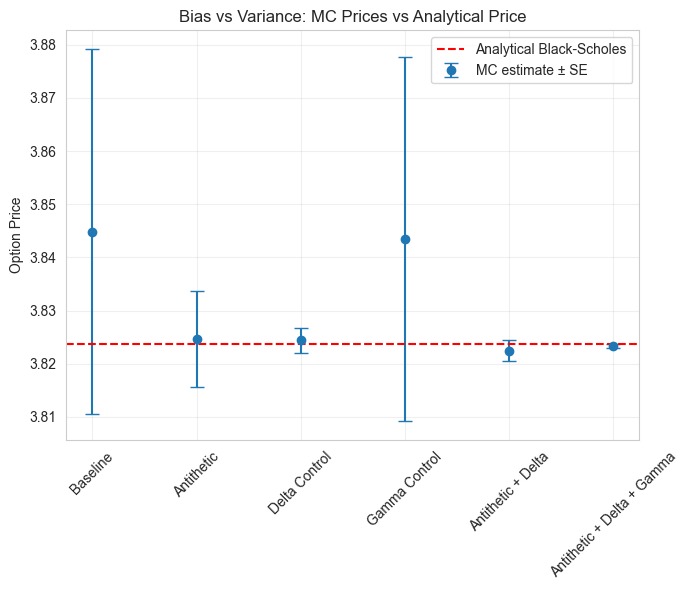

In [4]:
# Define MC variants and their corresponding functions
variants = ['Baseline', 'Antithetic', 'Delta Control', 'Gamma Control', 'Antithetic + Delta', 'Antithetic + Delta + Gamma']
mc_funcs = [
    mc_baseline,
    mc_antithetic,
    mc_delta_control,
    mc_gamma_control,
    mc_antithetic_delta,
    mc_antithetic_delta_gamma
]

# Run each MC variant and collect price and SE
mc_prices = []
SEs = []

for func in mc_funcs:
    price, SE, _ = func(S, X, vol, r, N, M, Z, T, type)
    mc_prices.append(price)
    SEs.append(SE)

# Compute analytical Black-Scholes price
bs_price = bs(r, S, X, T, vol, type)

# Create DataFrame for reference
df_bias = pd.DataFrame({
    'Variant': variants,
    'MC Price': mc_prices,
    'SE': SEs,
    'BS Price': [bs_price]*len(variants)
})

df_bias

# Plot Bias vs Variance
plt.figure(figsize=(7,6))
plt.errorbar(
    x=df_bias['Variant'],
    y=df_bias['MC Price'],
    yerr=df_bias['SE'],
    fmt='o',
    capsize=5,
    label='MC estimate ± SE',
    color='tab:blue'
)
plt.axhline(y=bs_price, color='r', linestyle='--', label='Analytical Black-Scholes')

plt.ylabel('Option Price')
plt.title('Bias vs Variance: MC Prices vs Analytical Price')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Monte Carlo methods have two key sources of error:

1. **Variance (Standard Error):**
   - Arises from the stochastic nature of simulation paths.  
   - Even with an unbiased estimator, the Monte Carlo price fluctuates around the true expected value.  
   - Decreases as the number of simulation paths (M) increases $$(SE \propto 1/\sqrt{M})$$
   - The standard error (SE) bars represent the range within which we expect the Monte Carlo price to fluctuate due to sampling variability. Larger SE indicates more uncertainty in the MC estimate, while smaller SE indicates higher precision. Typically, the SE is highest for options near-the-money and lower for deep in- or out-of-the-money options. 
   - Variance reduction techniques (antithetic, control variates) reduce SE without introducing significant bias.

2. **Bias:**
   - Systematic deviation from the true option value.  
   - Can be introduced by:
     - **Discretization of time steps** 
     - **Approximations in control variates** (if the reference model is imperfect).  
   - Unlike variance, bias does **not decrease by increasing M**; it is controlled by improving the model or using finer discretization.

### Trade-offs and Insights
- Increasing Number of Simulations (M) reduces variance but **cannot eliminate bias**.  
- Using variance reduction techniques can dramatically lower SE, but care must be taken to avoid introducing bias from the correction term.  
- The **ideal MC simulation** balances sufficient paths (low variance) with accurate modeling (minimal bias).  

## Comparing Monte Carlo Function variants (prices, SE, computation times)

In [5]:
df_benchmark = benchmark_mc_variants(S, X, vol, r, N, M, Z, T, type)
df_benchmark

,Function,Standard Error,Computation Time,Standard Error Reduction Multiple,Relative Computation Time
0,Vectorized Baseline,0.034317,0.002091,1.000000,1.000000
1,Antithetic Variates,0.009036,0.004145,3.797611,1.982326
2,Delta-based Control Variates,0.002375,0.012216,14.447800,5.842417
3,Gamma-based Control Variates,0.034198,0.007236,1.003470,3.460547
4,Antithetic AND Delta Variates,0.001898,0.019495,18.081299,9.323603
5,"Antithetic, Delta AND Gamma Variates",0.000402,0.027700,85.329272,13.247662


### Observations
- Applying variance reduction techniques—antithetic variates, delta control, and gamma control—consistently decreases the Monte Carlo standard error compared to the baseline simulation.  
- The magnitude of standard error reduction varies by method, with combined techniques providing the largest improvement.  
- There is a trade-off between computation time and precision: methods that reduce SE the most may require slightly more computation, but the efficiency gain per unit of SE reduction is substantial and quantifiable.  
- These results demonstrate the effectiveness of variance reduction strategies in improving simulation reliability and computational efficiency.

## Monte Carlo Efficiency Analysis

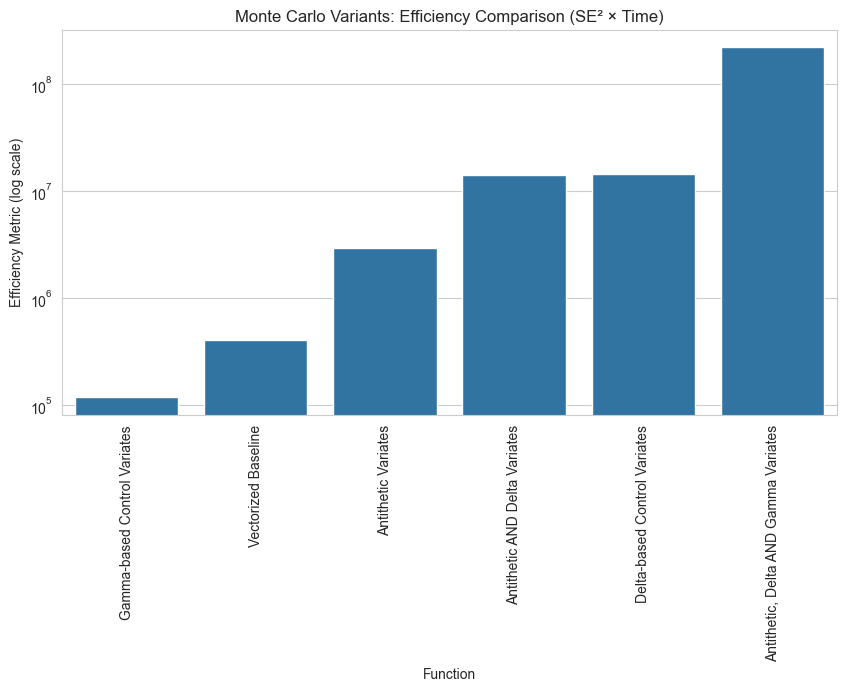

In [6]:
# Compute efficiency metric: SE^2 * Computation Time
df_benchmark['Efficiency'] = 1 / (df_benchmark['Standard Error']**2 * df_benchmark['Computation Time'])

# Sort by efficiency (lower is better)
df_benchmark_sorted = df_benchmark.sort_values('Efficiency')
df_benchmark_sorted

plt.figure(figsize=(10,5))
sns.barplot(x='Function', y='Efficiency', data=df_benchmark_sorted)
plt.title("Monte Carlo Variants: Efficiency Comparison (SE² × Time)")
plt.ylabel("Efficiency Metric (log scale)")
plt.yscale('log')  # <-- log scale
plt.xticks(rotation=90)
plt.show()

plt.show()

Efficiency combines accuracy (standard error) and computation time into a single metric:

$$
\text{Efficiency} = \frac{1}{(\text{SE})^2 \times \text{Computation Time}}
$$

- **Interpretation:** Higher efficiency indicates a method that achieves low variance in less time.  

### Observations
- **Gamma-based control:** Least efficient due to relatively high variance and extreme payoffs.  
- **Baseline:** Low efficiency; high variance dominates despite fast computation.  
- **Antithetic:** Moderate efficiency; variance reduced compared to baseline.  
- **Antithetic + Delta:** Better efficiency; variance further reduced.  
- **Delta-only:** High efficiency; bell-shaped distribution, concentrated payoffs.  
- **Antithetic + Delta + Gamma (Main MC method):** Highest efficiency; very narrow payoff distribution and low SE.

### Key Insights
- The efficiency ranking aligns perfectly with the payoff distributions: methods that produce more concentrated payoffs are quantitatively more efficient.

## Monte Carlo Payoff Distribution Analysis

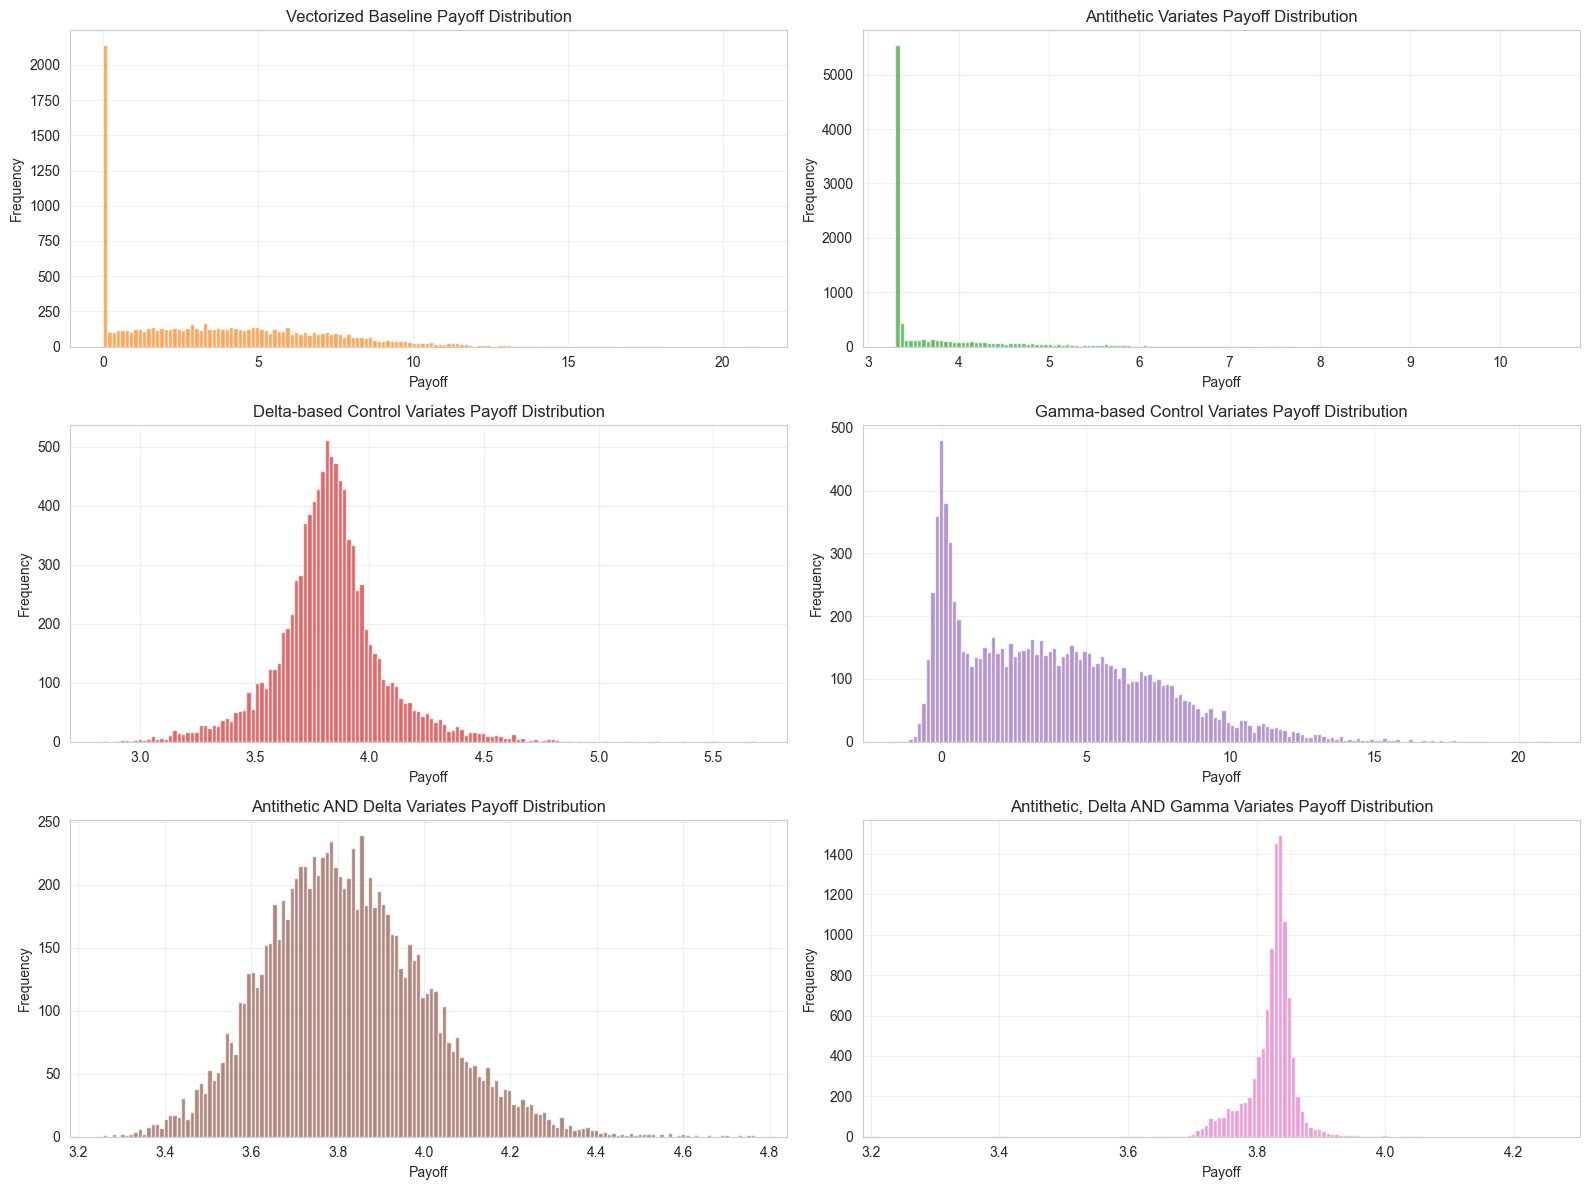

In [7]:
# ------------------------
# Dictionary of MC variants
# Key = display name, Value = function object
# ------------------------
mc_variants = {
    'Vectorized Baseline': mc_baseline,
    'Antithetic Variates': mc_antithetic,
    'Delta-based Control Variates': mc_delta_control,
    'Gamma-based Control Variates': mc_gamma_control,
    'Antithetic AND Delta Variates': mc_antithetic_delta,
    'Antithetic, Delta AND Gamma Variates': mc_antithetic_delta_gamma
}

# ------------------------
# Plot histograms
# ------------------------
plt.figure(figsize=(16,12))

for i, (name, func) in enumerate(mc_variants.items(), 1):
    # Generate simulated payoffs
    payoffs = func(S, X, vol, r, N, M, Z, T, type, True)
    
    # Plot subplot
    plt.subplot(3, 2, i)
    plt.hist(payoffs, bins=150, alpha=0.7, color='C'+str(i))
    plt.title(f'{name} Payoff Distribution')
    plt.xlabel('Payoff')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The payoff histograms illustrate how variance reduction techniques affect the spread and concentration of simulated option payoffs.

### Observations

#### Baseline
- Sharp spike at zero payoff.  
- Most paths are out-of-the-money, producing high variance and a wide distribution.  

#### Antithetic Variates
- Spike shifts closer to the expected payoff.  
- Pairing paths reduces extreme outcomes, concentrating payoffs near the mean.  

#### Delta-based Control Variates
- Bell-shaped distribution centered around the expected payoff.  
- Variance is reduced compared to baseline and antithetic, producing a more normal-like spread.  

#### Gamma-based Control Variates
- Slight negative payoffs may appear due to curvature corrections.  
- Distribution is moderately concentrated, but still has a wider tail than delta-based methods.  

#### Antithetic + Delta
- Combination further reduces variance.  
- Distribution is slightly wider at the peak than delta-only but more concentrated overall.  

#### Antithetic + Delta + Gamma
- Extremely narrow distribution around the expected payoff.  
- Demonstrates maximum variance reduction; almost all paths cluster near the mean.  

### Key Insight  
- Each added variance reduction technique narrows the distribution, reducing standard error and increasing simulation efficiency.  
- Sharp spikes in baseline and antithetic variants are expected and reflect the probability mass of out-of-the-money or clustered payoffs.

## Convergence Analysis of Monte Carlo Standard Error

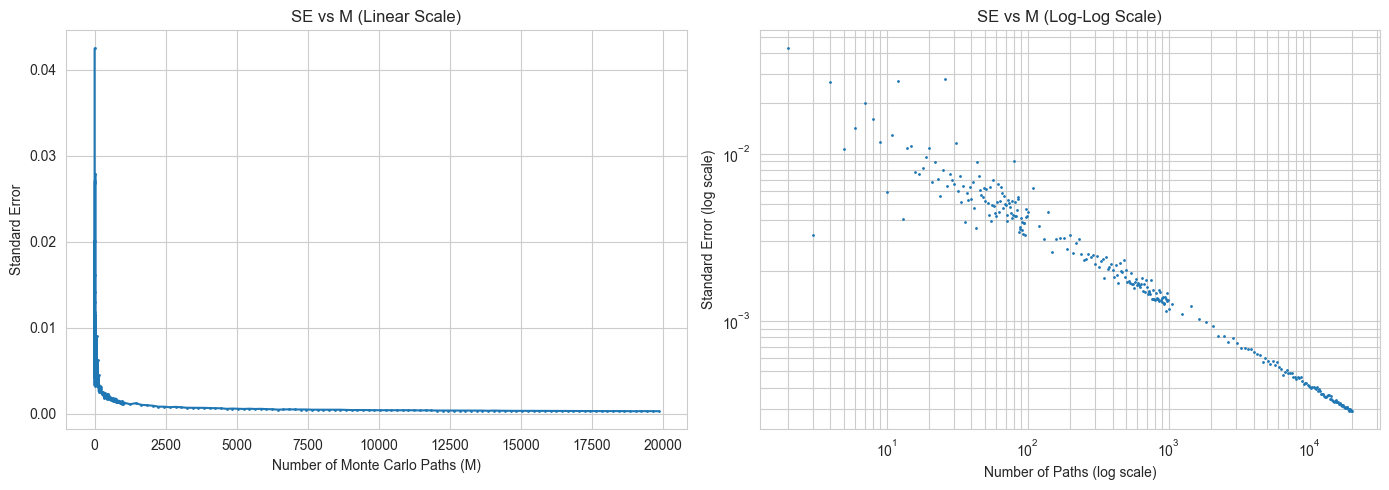

Estimated convergence rate (slope) ≈ -0.487


In [8]:
# Convergence analysis parameters
M_values = list(range(2, 101, 1)) + list(range(110, 1001, 10)) + list(range(1050, 20001, 200))
SEs = []

for m in M_values:
    Z_m = np.random.normal(size=(N, m))  # generate exactly m paths
    _, SE, _ = mc_antithetic_delta_gamma(S, X, vol, r, N, m, Z_m, T, type)
    SEs.append(SE)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Linear plot (SE vs M)
axes[0].plot(M_values, SEs, marker='.', markersize=2)
axes[0].set_xlabel("Number of Monte Carlo Paths (M)")
axes[0].set_ylabel("Standard Error")
axes[0].set_title("SE vs M (Linear Scale)")
axes[0].grid(True)

# Log-log plot
axes[1].loglog(M_values, SEs, marker='.', markersize=2, linestyle='None')
axes[1].set_xlabel("Number of Paths (log scale)")
axes[1].set_ylabel("Standard Error (log scale)")
axes[1].set_title("SE vs M (Log-Log Scale)")
axes[1].grid(True, which="both")

plt.tight_layout()
plt.show()

# Calculate slope on log-log scale
logM = np.log(M_values)
logSE = np.log(SEs)
slope, intercept = np.polyfit(logM, logSE, 1)
print(f"Estimated convergence rate (slope) ≈ {slope:.3f}")

### Observations

The two plots show how the standard error (SE) decreases as the number of Monte Carlo paths (M) increases.

- **Linear plot (left):** SE decreases with M following a decaying curve (~1/√M). The curve is steep for small M and flattens as M grows.
- **Log-log plot (right):** SE vs M on log-log axes produces a nearly straight line. This confirms the theoretical convergence rate of Monte Carlo simulations.
- **Observation:** 
    - For small M, SE estimates are noisy → points are scattered.  
    - For large M, SE stabilizes → points align along the straight line.
- **Conclusion:** Convergence behavior is as expected, and the slope closely matches the theoretical −0.5.

## Sensitivity Analysis of Option Price and Standard Error

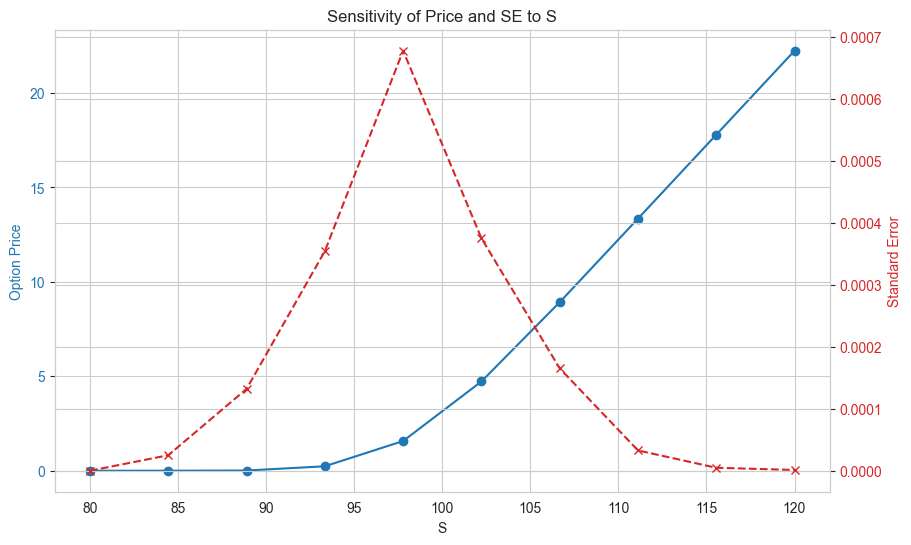

In [9]:
# %%
import matplotlib.pyplot as plt
import numpy as np

# Sensitivity analysis parameters
param_name = 'S'  # choose which parameter to vary: 'S', 'X', 'vol', 'T'
param_values = np.linspace(80, 120, 10)  # example range

prices = []
SEs = []

for val in param_values:
    # Set parameters for this iteration
    S_val = val if param_name == 'S' else S
    X_val = val if param_name == 'X' else X
    vol_val = val if param_name == 'vol' else vol
    T_val = val if param_name == 'T' else T

    # Generate Z
    Z_m = np.random.normal(size=(N, M))  # M = number of paths, N = timesteps

    # Run main MC function
    price, SE, _ = mc_antithetic_delta_gamma(S_val, X_val, vol_val, r, N, M, Z_m, T_val, type)
    prices.append(price)
    SEs.append(SE)

# Plot results
fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:blue'
ax1.set_xlabel(param_name)
ax1.set_ylabel('Option Price', color=color)
ax1.plot(param_values, prices, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Standard Error', color=color)
ax2.plot(param_values, SEs, marker='x', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"Sensitivity of Price and SE to {param_name}")
plt.show()

### Observations

The plot shows how the option price (blue line) and Monte Carlo standard error (red dashed line) change as a parameter (e.g., underlying price S) varies.

- **Blue line (Option Price):**  
  - The curve is **non-linear** when the option is far out-of-the-money.  
  - Only after approaching or surpassing the strike (near the SE peak) does the price growth become approximately linear.  
  - This reflects the **convexity of option payoff**: deep out-of-the-money options have low price sensitivity to changes in S.  

- **Red dashed line (Standard Error):**  
  - Peaks at-the-money, where payoff variability is highest.  
  - Low SE when deep in/out-of-the-money, consistent with fewer paths producing significant payoffs.  

### Key Insights 
- The curved portion of the blue line highlights the **non-linear response** of option price to the underlying.  
- The linear-ish region beyond the SE peak indicates a **more predictable, nearly linear price response**.  
- This analysis helps identify regions where **Monte Carlo estimates are less precise** and where additional paths may be needed.

## Monte Carlo SE Heatmap: Volatility vs Time to Maturity

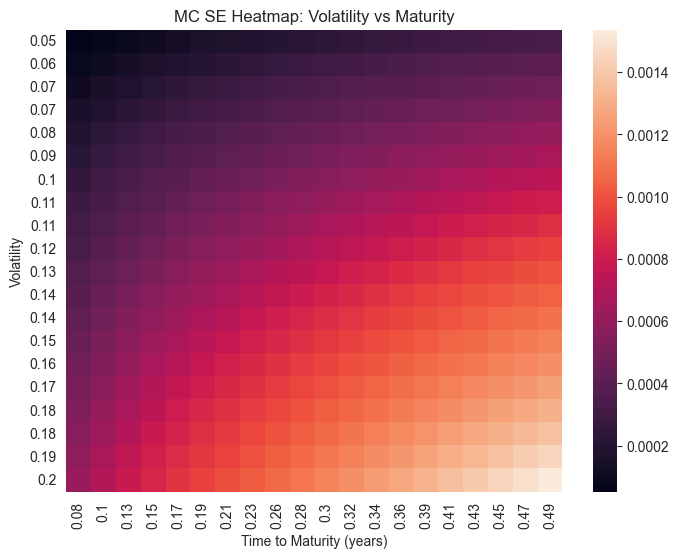

In [10]:
vols = np.linspace(0.05, 0.2, 20)
Ts = np.linspace(30/365, 180/365, 20)
heatmap_data = np.zeros((len(vols), len(Ts)))

for i, vol_i in enumerate(vols):
    for j, T_j in enumerate(Ts):
        _, SE, _ = mc_antithetic_delta_gamma(S, X, vol_i, r, N, M, Z, T_j, type)
        heatmap_data[i, j] = SE

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, xticklabels=np.round(Ts,2), yticklabels=np.round(vols,2))
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Volatility")
plt.title("MC SE Heatmap: Volatility vs Maturity")
plt.show()

### Observations
This heatmap illustrates how the Monte Carlo standard error (SE) varies across different volatilities (σ) and times to maturity (T).

- **Impact of maturity:** SE generally increases for longer maturities, as simulated paths have more steps and more potential payoff variability.  
- **Impact of volatility:** SE increases with higher volatility because payoff dispersion is greater.  
- **Interaction effects:** Regions with both high volatility and long maturity exhibit the largest SE, indicating the highest Monte Carlo uncertainty.  
- **Low SE regions:** Short maturities and low volatility result in smaller SE, reflecting more predictable payoffs.

### Key Insights
This heatmap provides a 2D view of where Monte Carlo estimates are most and least precise, complementing the Strike vs Volatility heatmap and highlighting areas that may require more simulation paths for reliable pricing.

## Monte Carlo SE Heatmap: Strike vs Volatility

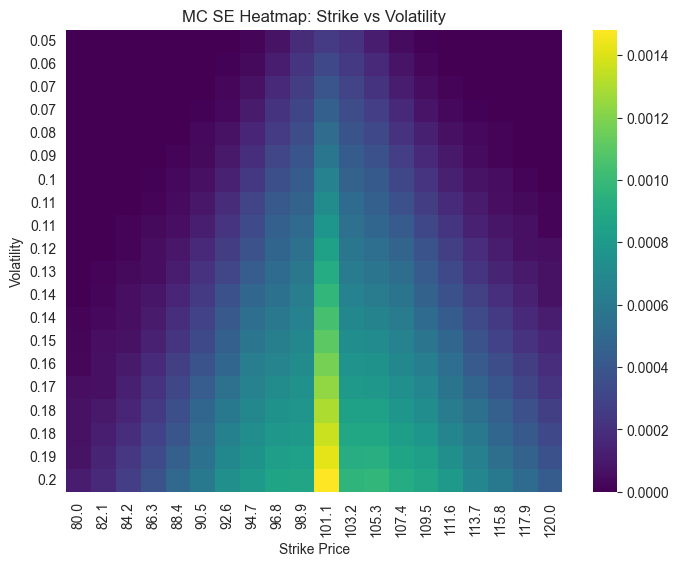

In [11]:
strikes = np.linspace(80, 120, 20)  # example range around S
vols = np.linspace(0.05, 0.2, 20)

heatmap_data = np.zeros((len(vols), len(strikes)))

# Compute SE for each combination
for i, vol_i in enumerate(vols):
    for j, X_j in enumerate(strikes):
        _, SE, _ = mc_antithetic_delta_gamma(S, X_j, vol_i, r, N, M, Z, T, type)
        heatmap_data[i, j] = SE

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, 
            xticklabels=np.round(strikes,1), 
            yticklabels=np.round(vols,2),
            cmap="viridis")
plt.xlabel("Strike Price")
plt.ylabel("Volatility")
plt.title("MC SE Heatmap: Strike vs Volatility")
plt.show()

### Observations
This heatmap illustrates how the Monte Carlo standard error (SE) varies across different strike prices (X) and volatilities (σ).

- **Peak SE near-the-money:** The largest uncertainty occurs when the strike price is close to the underlying price, reflecting high payoff variability.  
- **Effect of volatility:** SE generally increases as volatility rises, since higher volatility amplifies payoff dispersion.  
- **Low SE in extreme regions:** Deep in-the-money or out-of-the-money options show lower SE because payoffs are more consistent.  
- **Practical insight:** Regions with higher SE indicate where more Monte Carlo paths may be needed for reliable pricing.  

### Key Insights:
This heatmap provides a quantitative 2D view of where Monte Carlo estimates are most and least precise, complementing previous sensitivity and convergence analyses.

# Conclusion from Monte Carlo Analysis

- **Variance Reduction:** Combining antithetic, delta, and gamma control variates consistently yields the lowest standard error, demonstrating the effectiveness of variance reduction techniques.  
- **Convergence Behavior:** Increasing the number of simulation paths (M) reduces SE according to the expected $$(1/\sqrt{M})$$ rate, with diminishing returns for very large M.  
- **Price Sensitivity:** Sensitivity analysis shows how option price and SE respond to underlying price (S), strike (X), volatility (σ), and time to maturity (T), with SE peaking near-the-money and for high volatility or long maturities.  
- **Greeks Accuracy:** Monte Carlo estimates of Greeks generally align with Black-Scholes analytical values within SE. Theta is noisier due to finite-difference estimation, but higher N/M improves stability.  
- **Bias vs Variance:** MC prices are unbiased, and SE bars reflect the uncertainty of the estimates. The Bias vs Variance plot visually confirms the trade-off between precision and sampling variability.  
- **Heatmap Analysis:** SE heatmaps (Volatility vs Maturity, Strike vs Volatility) highlight regions of highest Monte Carlo uncertainty, indicating where more simulation paths may be needed for reliable pricing.  

**Overall:** The notebook demonstrates a comprehensive quantitative understanding of Monte Carlo pricing, variance reduction, convergence, sensitivity, and risk analysis for European options.